# Visualizations

This notebook recreates all the visualizations found in my post

http://franksh.com/posts/berlin-names/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pdb
%matplotlib inline

import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

# from matplotlib import rcParams
# params = {
#    'axes.labelsize': 16,
# #    'text.fontsize': 8,
#    'legend.fontsize': 12,
#    'xtick.labelsize': 12,
#    'ytick.labelsize': 12,
#    'text.usetex': False,
# #    'figure.figsize': [4.5, 4.5]
#     'font.family': 'sans-serif',
#     'font.sans-serif': 'Source Sans Pro',
#    }
# rcParams.update(params)

import bokeh.plotting as bk
# from bokeh import mpl

bk.output_notebook()

Loading BokehJS ...

### Color palettes

- Red palette (contiuous)
- Spectral palette (categorical) 


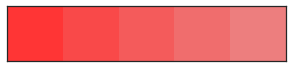

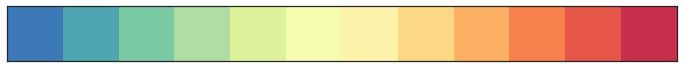

In [47]:
from colour import Color
# Red palette
lightred = Color("#ED7E7E")
darkred = Color("#FF3636")
color_red = [c.rgb for c in list(darkred.range_to(lightred, 5))]
print("- Red palette (contiuous)")
print("- Spectral palette (categorical) ")
sns.palplot(color_red)
# Sequential palette
color_spectral = sns.color_palette('Spectral', n_colors=12)[::-1]
sns.palplot(color_sequential)

In [3]:
def load_data():
    " Loads and returns the dataframe "    
    data_path = '../data/'
    df = pd.read_csv(data_path + 'processed/namedata.csv', sep=',')
    return df

df = load_data()
df.head()   

,anzahl,bezirk,frequency,geschlecht,vorname,year
0,122,Charlottenburg-Wilmersdorf,0.013676,w,Marie,2012
1,105,Charlottenburg-Wilmersdorf,0.011770,w,Sophie,2012
2,78,Charlottenburg-Wilmersdorf,0.008743,w,Charlotte,2012
3,69,Charlottenburg-Wilmersdorf,0.007735,w,Maria,2012
4,66,Charlottenburg-Wilmersdorf,0.007398,m,Paul,2012


In [43]:
def load_demography():
    demography = pd.read_csv('../data/raw/EWR_Ortsteile_2016-06-30.csv', sep=';', encoding='latin-1')
    demography = demography.drop(['Bezirk','Ortsteil','Ortst-Name'], axis=1)
    demography = demography.rename(columns={'Bez-Name': 'bezirk'})
    return demography

demography = load_demography()
demography.head()

,bezirk,Geschl,Staatsangeh,Altersgr,Häufigkeit
0,Mitte,1,A,00_05,375
1,Mitte,1,A,05_10,335
2,Mitte,1,A,10_15,249
3,Mitte,1,A,15_20,291
4,Mitte,1,A,20_25,933


In [44]:
population = demography.groupby(by='bezirk').sum()['Häufigkeit']
population.name = 'population'
population.head()

bezirk
Charlottenburg-Wilmersdorf    334351
Friedrichshain-Kreuzberg      281076
Lichtenberg                   280721
Marzahn-Hellersdorf           261954
Mitte                         368122
Name: population, dtype: int64

# Most popular names

In [18]:
from bokeh.palettes import Spectral11
from bokeh.layouts import row

def plot_popular_names_bars_bokeh(df, n=10):
    " Plot count of most popular names as bar chart"
    color = [c.hex for c in list(darkred.range_to(lightred, n))]
    barcharts = []
    for gender in ['w', 'm']:
        df_gender = df[ (df['geschlecht'] == gender) & (df['year']==2017) ]
        counts_over_time = df_gender.groupby(by=['vorname', 'year']).sum()#.sort_values(by='anzahl',ascending=False)
        counts_total = df_gender.groupby(by=['vorname']).sum()
        counts_total = counts_total.sort_values(by='anzahl', ascending=False).head(n)
        counts_total['rank'] = range(len(counts_total))[::-1]
        counts_total['color'] = color

        p = bk.figure(
                x_range=(0,counts_total['anzahl'].max()*1.1), 
                y_range=counts_total.index.values.tolist()[::-1],
                plot_height=300, plot_width=350,
                toolbar_location=None, tools="",
                sizing_mode = 'scale_width',
            )

        p.hbar(y='vorname', right='anzahl', height=0.5, color='color', source=counts_total)
        p.xaxis.axis_label_text_font_size = '1em'
        p.xaxis.major_label_text_font_size = '0.75em'
        p.yaxis.major_label_text_font_size = '1em'
        p.xaxis.minor_tick_line_color = None
        p.ygrid.grid_line_color = None
        p.xaxis.axis_label = "count"
        p.xaxis.axis_label_text_font_style = "normal"
        barcharts.append(p)

    return barcharts

barcharts = plot_popular_names_bars_bokeh(df, n=10)
from bokeh.embed import components

# 0: girls, 1: boys
p = barcharts[1]

# Output scripts, div
script, div = components(p)
bk.reset_output()
bk.output_notebook()
p.sizing_mode = 'fixed'
# bk.show(barcharts[0], sizing_mode='fixed')
bk.show(p)

Loading BokehJS ...

## Trending names

In [36]:
from bokeh.palettes import Spectral11
from bokeh.models import Legend

def plot_trendiest_names_bokeh(df, gender, n=10, cutoff=50):
    """ 
    Plots a lineplot/sparkplot of the "trendiness" names.
    Trendiness is calculated as the absolute difference in count
    between 2012 and 2017
    
    Parameters:
    - Cutoff = only names with higher count are ranked
    """
    # Compute the "trendiness"
    trend = df.copy()
    trend = trend.groupby(by=['vorname', 'geschlecht', 'year']).sum().reset_index(level=2)
    trend = trend.pivot(columns='year')['anzahl'].sort_values(by=2017, ascending=False)
    trend = trend.reset_index()
    trend = trend[ trend['geschlecht'] == gender ]
    # Absolute
    trend['trend'] = (trend[2017] - trend[2012])
    trend = trend.drop([2013, 2014, 2015, 2016], axis=1)
    trend = trend.set_index('vorname')

    # Set color palettes for rising/falling trends as end of 'Spectral' palette
    colors_rising = sns.color_palette('Spectral_r', n_colors=int(n*2.5)).as_hex()[0:n]
    colors_falling = sns.color_palette('Spectral', n_colors=int(n*2.5)).as_hex()[0:n]

    lines = []
    charts = []
    # Create two plots: rising trend, falling trend
    for trend_direction, colors in zip(['rising', 'falling'], [colors_rising, colors_falling]):
        trendlines = trend.sort_values(by='trend', ascending=False if trend_direction=='rising' else True)
        trendlines = trendlines.head(n)
        
        p = bk.figure(plot_width=250, plot_height=200, x_range=[2012, 2017],
                     toolbar_location=None, title=trend_direction,
                      sizing_mode = 'scale_width',
                     )
        lines = []
        legend_items = []
        for (name, data), color in zip(trendlines.iterrows(), colors):
            line = p.line(x='x', y='y',
                          muted_alpha=0.1, line_width=5, line_alpha=0.9,
                          line_color=color,
                          source=pd.DataFrame({
                                'x': [2012, 2017],
                                'y': [data[2012], data[2017]],
                                'name': [name for i in [2012, 2017]],
                            }),
                          )
            lines.append(line)
            legend_items.append((name, [line]))
            
        # Manual legend
        legend = Legend(items=legend_items, label_text_font_size='1em')
        
        # Plot styling
        p.add_layout(legend, 'right')
        p.legend.click_policy = 'mute'
        p.legend.border_line_width = 2
        p.legend.border_line_color = "grey"
        p.legend.border_line_alpha = 0.3
        # Axes
        p.xaxis.major_label_text_font_size = '1em'
        p.yaxis.major_label_text_font_size = '0.75em'
        p.xaxis.minor_tick_line_color = None
        p.yaxis.minor_tick_line_color = None
        p.xaxis.ticker = [2012, 2017]
        p.xaxis.axis_label_text_font_size = '1em'
        p.xgrid.grid_line_color = None
        p.xaxis.axis_label = "count"
        p.xaxis.axis_label_text_font_style = "normal"
        # Titles
        p.title.align='center'
        p.title.text_font = 'Helvetica'
        p.title.text_font_size = '1em'
        p.title.text_font_style = "normal"
        
        charts.append(p)
        
    return charts 
        
charts = plot_trendiest_names_bokeh(df, gender='m', n=5, cutoff=70)

# Get the components of chart. These can be imbedded in html
from bokeh.embed import components
script, div = components(charts[1])

In [37]:
from bokeh.layouts import row
from bokeh.embed import components
bk.show(row(charts, sizing_mode='scale_width'))

# General: Babies in districts

In [38]:
counts_districts = df.copy()
# counts['bezirk'] = counts['bezirk'].apply(str.title).str.replace('oe', 'ö')
counts_districts = counts_districts.groupby(by=['bezirk','year']).count()['anzahl']
counts_districts.to_csv('../data/processed/counts.csv', header=True)
counts_districts.head()

counts_pivoted = counts_districts.reset_index(level=0).pivot(columns='bezirk')
start_values = counts_pivoted['anzahl'].loc[2012]
freq_change = counts_pivoted['anzahl'] / start_values

### Number of babies over time

In [41]:
from bokeh.palettes import Spectral11
from bokeh.models import Legend, HoverTool

bk.reset_output()
bk.output_notebook()

hover = HoverTool(tooltips='@name')

p = bk.figure(toolbar_location="above", plot_width=750, plot_height=400, x_range=[2012, 2017],
              tools=[hover])

colors = sns.color_palette('Spectral', n_colors=12).as_hex()[::-1]

lines = []
for bezirk, color in zip(counts_pivoted['anzahl'].columns.values, colors):
    line = p.line('x', 'y',
            line_color = color,
           line_width = 5,
          line_alpha = 0.9,
#            legend=bezirk,
        source=pd.DataFrame({
            'x': counts_pivoted.index.values,
            'y': counts_pivoted['anzahl'][bezirk],
            'name': [bezirk for i in range(2012,2018)],
        }),
           muted_alpha=0.1,
          )
    lines.append(line)

# Manual legend
legend = Legend(items=[(bezirk, [line]) for bezirk, line in zip(counts_pivoted['anzahl'].columns.values, lines)],
               location = (10,50))
p.add_layout(legend, 'right')
p.legend.click_policy = 'mute'

p.legend.border_line_width = 2
p.legend.border_line_color = "grey"
p.legend.border_line_alpha = 0.3

bk.show(p)

Loading BokehJS ...

In [26]:
bk.save(p, filename='bokehtest.html')

/usr/local/lib/python3.6/site-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/usr/local/lib/python3.6/site-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


'/Users/frank/GitHub/OTHER/berlin-names/notebooks/bokehtest.html'

In [48]:
from bokeh.palettes import Spectral11
from bokeh.models import Legend

bk.reset_output()
bk.output_notebook()

p = bk.figure(toolbar_location="above", plot_width=750, plot_height=400, x_range=[2012, 2017])

colors = sns.color_palette('Spectral', n_colors=12).as_hex()[::-1]

lines = []
for bezirk, color in zip(freq_change.columns.values, colors):
    line = p.line(freq_change.index.values, freq_change[bezirk],
            line_color = color,
           line_width = 5,
          line_alpha = 0.9,
#            legend=bezirk,
           muted_alpha=0.1,
          )
    lines.append(line)

# Manual legend
legend = Legend(items=[(bezirk, [line]) for bezirk, line in zip(freq_change.columns.values, lines)],
               location = (10,50))
p.add_layout(legend, 'right')
p.legend.click_policy = 'mute'

p.legend.border_line_width = 2
p.legend.border_line_color = "grey"
p.legend.border_line_alpha = 0.3

bk.show(p)

Loading BokehJS ...

### Comparison: Size vs. Growth

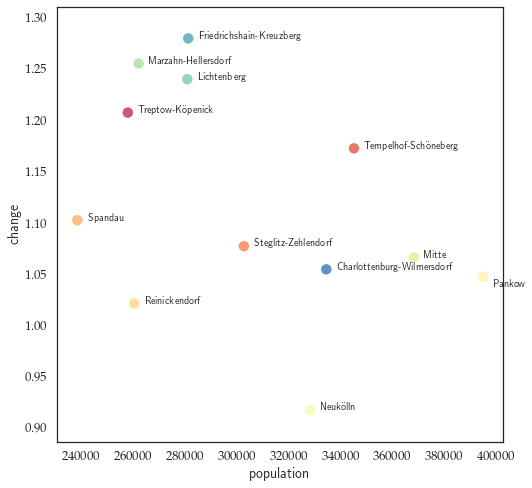

In [49]:
fig, ax = plt.subplots(1, figsize=(8,8))
districtsize = counts_districts.groupby(by='bezirk').sum()
totalchange = freq_change.loc[2017]

# compare = pd.concat([districtsize, totalchange], axis=1)
# compare.plot(kind='scatter', x='anzahl', y=2017, ax=ax, alpha=0.5)

compare = pd.concat([population, totalchange], axis=1)
compare.plot(kind='scatter', x='population', y=2017, ax=ax, alpha=0.8, s=100, color=color_spectral)

for name, values in compare.iterrows():
    height = values[2017] if name!='Pankow' else values[2017]-0.01
    ax.annotate(name, (values['population']+4000, (height)))
    
ax.set_ylabel('change')
plt.show()

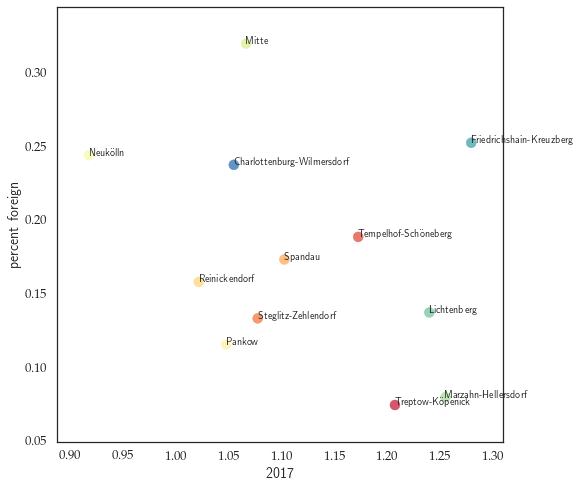

In [53]:
staatsangeh = demography.groupby(by=['Staatsangeh', 'bezirk']).sum()
foreign = staatsangeh.loc['A']
german = staatsangeh.loc['D']
percent_foreign = (foreign / (german+foreign))["Häufigkeit"]

fig, ax = plt.subplots(1, figsize=(8,8))

totalchange = freq_change.loc[2017]

compare = pd.concat([totalchange, percent_foreign], axis=1)
compare.plot(kind='scatter', x=2017, y='Häufigkeit', ax=ax, alpha=0.8, s=100, color=color_spectral)

for name, values in compare.iterrows():
#     height = values['Häufigkeit'] if name!='Pankow' else values[2017]-0.01
    height = values['Häufigkeit']
    ax.annotate(name, (values[2017], (height)))
    
ax.set_ylabel('percent foreign')
plt.show()

In [49]:
counts_districts.groupby(by=['bezirk', 'Staatsangeh']).sum()

KeyError: 'Staatsangeh'